# CDSDS 542 Deep Learning for Data Science - Discussion 10: Generative Adversarial Network (GAN)
## 0. GANs

- Generative Adversarial Networks refer to a family of generative models that seek to discover the underlying distribution behind a certain data generating process. This distribution is discovered through an adversarial competition between a generator and a discriminator.

    - Discriminator: Tries to distinguish between real and fake samples.
    - Generator: Tries to confuse the discriminator by producing data that are as realistic and compelling as possible

![image](https://developer.ibm.com/developer/default/articles/generative-adversarial-networks-explained/images/GANs.jpg)


### 0.1 Discriminator

The goal of the discriminator is to correctly label generated images as false and empirical data points as true. Therefore, we might consider the following to be the loss function of the discriminator:

$$ L_D=Error(D(x),1)+Error(D(G(z)),0)$$

### 0.2 Generator

We can go ahead and do the same for the generator. The goal of the generator is to confuse the discriminator as much as possible such that it mislabels generated images as being true.

$$ L_G=Error(D(G(z)),1)$$

In the case of the generator, it should strive to minimize the difference between 1, the label for true data, and the discriminator’s evaluation of the generated fake data.

### 0.3 Binary Cross Entropy

$$ BCE(y,\hat{y}) = - \sum_{i=1}^{n} y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)$$

Applying BCE to the discriminator and generator loss functions, we get the following:

$$ L_D = - \sum_{i=1}^{n} log(D(x_i)) + log(1-D(G(z_i)))$$
$$ L_G = - \sum_{i=1}^{n} log(D(G(z_i)))$$




In [ ]:
# module
import os
import time
import tarfile
import warnings
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from pathlib import Path
from IPython import display as ipy_display

import torch
import torchvision
from torch import nn
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

## 1. Load the images
Using ArtBench10 Dataset, see: https://github.com/liaopeiyuan/artbench/tree/main?tab=readme-ov-file

ArtBench10 already exists.
Metadata already exists.
Found 443 artworks by albrecht-durer
Found 368 artworks by raphael-kirchner


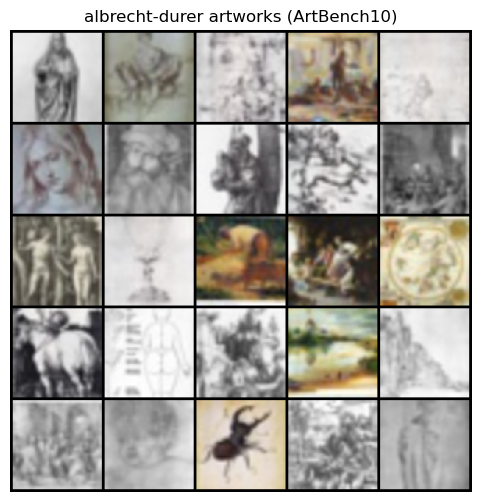

In [ ]:
# load the dataset class
class ArtBench10(CIFAR10):
    base_folder = "artbench-10-batches-py"
    url = "https://artbench.eecs.berkeley.edu/files/artbench-10-python.tar.gz"
    filename = "artbench-10-python.tar.gz"
    tgz_md5 = "9df1e998ee026aae36ec60ca7b44960e"
    train_list = [
        ["data_batch_1", "c2e02a78dcea81fe6fead5f1540e542f"],
        ["data_batch_2", "1102a4dcf41d4dd63e20c10691193448"],
        ["data_batch_3", "177fc43579af15ecc80eb506953ec26f"],
        ["data_batch_4", "566b2a02ccfbafa026fbb2bcec856ff6"],
        ["data_batch_5", "faa6a572469542010a1c8a2a9a7bf436"],
    ]
    test_list = [["test_batch", "fa44530c8b8158467e00899609c19e52"]]
    meta = {
        "filename": "meta",
        "key": "styles",
        "md5": "5bdcafa7398aa6b75d569baaec5cd4aa",
    }


# download the dataset
root = "./data"
if not os.path.exists(os.path.join(root, ArtBench10.base_folder)):
    print("Downloading ArtBench10...")
    dataset = ArtBench10(root=root, train=True, download=True)
else:
    print("ArtBench10 already exists.")
    dataset = ArtBench10(root=root, train=True, download=False)

meta_path = os.path.join(root, "artbench-10-metadata.csv")
if not os.path.exists(meta_path):
    print("Downloading metadata...")
    urllib.request.urlretrieve("https://artbench.eecs.berkeley.edu/files/ArtBench-10.csv", meta_path)
else:
    print("Metadata already exists.")


# filter with artist
meta = pd.read_csv(meta_path)
durer_indices = meta[meta["artist"] == "albrecht-durer"]["cifar_index"].tolist()
print(f"Found {len(durer_indices)} artworks by albrecht-durer")
kirchner_indices = meta[meta["artist"] == "raphael-kirchner"]["cifar_index"].tolist()
print(f"Found {len(kirchner_indices)} artworks by raphael-kirchner")


# create dataloaders
transformer = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset.transform = transformer

batch_size = 128
num_workers = min(8, torch.get_num_threads())

durer_subset = Subset(dataset, durer_indices)
durer_dataloader = DataLoader(durer_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
kirchner_subset = Subset(dataset, kirchner_indices)
kirchner_dataloader = DataLoader(kirchner_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# sample Dürer images
imgs, labels = next(iter(durer_dataloader))
imgs = imgs * 0.5 + 0.5
grid = make_grid(imgs[:25], nrow=5)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.title("albrecht-durer artworks (ArtBench10)")
plt.show()

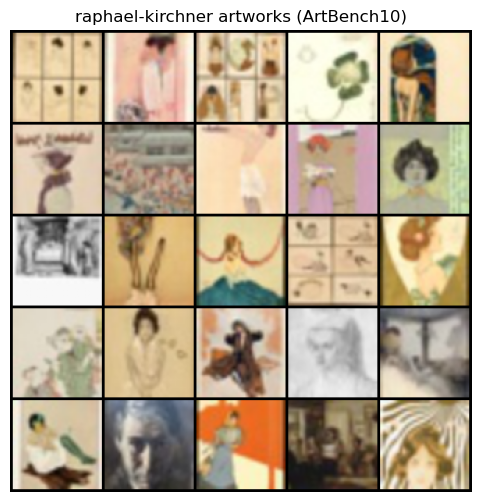

In [ ]:
# sample Kirchner images
imgs, labels = next(iter(kirchner_dataloader))
imgs = imgs * 0.5 + 0.5

grid = make_grid(imgs[:25], nrow=5)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.title("raphael-kirchner artworks (ArtBench10)")
plt.show()

In [ ]:
# tool functions
class Timer:
    def __init__(self):
        self.start_time = time.time()

    def stop(self):
        return time.time() - self.start_time

# update by epochs
class Animator:
    def __init__(self, xlabel='', ylabel='', xlim=None, nrows=1,
                 figsize=(5, 5), legend=None):
        fig, axes = plt.subplots(nrows, 1, figsize=figsize)
        if nrows == 1:
            axes = [axes]
        else:
            axes = axes.flatten().tolist()
        self.fig = fig
        self.axes = axes
        self.legend = legend or []
        self.lines = []
        labels = self.legend or ['']
        for label in labels:
            (line,) = self.axes[0].plot([], [], label=label if label else None)
            self.lines.append(line)
        if self.legend:
            self.axes[0].legend()
        self.axes[0].set_xlabel(xlabel)
        self.axes[0].set_ylabel(ylabel)
        if xlim:
            self.axes[0].set_xlim(xlim)
        self.x_data = [[] for _ in self.lines]
        self.y_data = [[] for _ in self.lines]

    def add(self, x, ys):
        if not isinstance(ys, (list, tuple)):
            ys = [ys]
        for i, y in enumerate(ys):
            self.x_data[i].append(x)
            self.y_data[i].append(y)
            self.lines[i].set_data(self.x_data[i], self.y_data[i])
        self.axes[0].relim()
        self.axes[0].autoscale_view()
        ipy_display.clear_output(wait=True)
        ipy_display.display(self.fig)

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

## 2. The Generator

(This is a Deep Convolutional GAN)

The generator needs to map the noise variable $\mathbf z\in\mathbb R^d$, a length-$d$ vector, to a RGB image with width and height to be $64\times 64$ . The basic block of the generator contains a transposed convolution layer followed by the batch normalization and ReLU activation.


In [ ]:
# TODO: define the G_block
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2, padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In default, the transposed convolution layer uses a $k_h = k_w = 4$ kernel, a $s_h = s_w = 2$ strides, and a $p_h = p_w = 1$ padding. With a input shape of $n_h^{'} \times n_w^{'} = 16 \times 16$, the generator block will double input's width and height.

$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= [(n_h k_h - (n_h-1)(k_h-s_h)- 2p_h] \times [(n_w k_w - (n_w-1)(k_w-s_w)- 2p_w]\\
  &= [(k_h + s_h (n_h-1)- 2p_h] \times [(k_w + s_w (n_w-1)- 2p_w]\\
  &= [(4 + 2 \times (16-1)- 2 \times 1] \times [(4 + 2 \times (16-1)- 2 \times 1]\\
  &= 32 \times 32 .\\
\end{aligned}
$$

In [ ]:
x = torch.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk(x).shape

torch.Size([2, 20, 32, 32])

The generator consists of four basic blocks that increase input's both width and height from 1 to 32. At the same time, it first projects the latent variable into $64\times 8$ channels, and then halve the channels each time. At last, a transposed convolution layer is used to generate the output. It further doubles the width and height to match the desired $64\times 64$ shape, and reduces the channel size to $3$. The tanh activation function is applied to project output values into the $(-1, 1)$ range.


In [ ]:
# Generator
n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G*8,
            strides=1, padding=0),                  # Output: (64 * 8, 4, 4)
    G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 8, 8)
    G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 16, 16)
    G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())                                      # Output: (3, 64, 64)

Verify the generator's output shape with 100 dimensional latent variable.

In [ ]:
x = torch.zeros((1, 100, 1, 1))
net_G(x).shape

torch.Size([1, 3, 64, 64])

## 3. Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function.

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyperparameters of the convolution layer are similar to the transpose convolution layer in the generator block.

In [ ]:
# TODO: define the D_block
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, alpha=0.2, use_dropout=False, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)
        self.dropout = nn.Dropout(0.2) if use_dropout else nn.Identity()

    def forward(self, X):
        X = self.conv2d(X)
        X = self.batch_norm(X)
        X = self.activation(X)
        X = self.dropout(X)
        return X

A basic block with default settings will halve the width and height of the inputs. Given a input shape $n_h = n_w = 16$, with a kernel shape $k_h = k_w = 4$, a stride shape $s_h = s_w = 2$, and a padding shape $p_h = p_w = 1$, the output shape will be:

$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= \lfloor(n_h-k_h+2p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+2p_w+s_w)/s_w\rfloor\\
  &= \lfloor(16-4+2\times 1+2)/2\rfloor \times \lfloor(16-4+2\times 1+2)/2\rfloor\\
  &= 8 \times 8 .\\
\end{aligned}
$$


In [ ]:
x = torch.zeros((2, 3, 16, 16))
d_blk = D_block(20)
d_blk(x).shape

torch.Size([2, 20, 8, 8])

In [ ]:
# Discriminator
net_D = nn.Sequential(
    D_block(64, use_dropout=True),
    D_block(64*2, in_channels=64, use_dropout=True),
    D_block(64*4, in_channels=64*2, use_dropout=True),
    D_block(64*8, in_channels=64*4, use_dropout=True),
    nn.Conv2d(64*8, 1, kernel_size=4, bias=False),
    nn.Sigmoid()
)

It uses a convolution layer with output channel  1  as the last layer to obtain a single prediction value.

In [ ]:
x = torch.zeros((1, 3, 64, 64))
net_D(x).shape

torch.Size([1, 1, 1, 1])

## 4. Training

* Notice that we have different optimizers for the discriminator and the generator. This is expected, since we are going to be training two different networks in a different manner.

In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim, device=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    loss_fn = nn.BCELoss(reduction='mean')

    # weight initialization
    net_D.apply(weights_init)
    net_G.apply(weights_init)
    net_D, net_G = net_D.to(device), net_G.to(device)

    opt_D = torch.optim.Adam(net_D.parameters(), lr=lr * 0.5, betas=(0.5, 0.999))
    opt_G = torch.optim.Adam(net_G.parameters(), lr=lr, betas=(0.5, 0.999))

    animator = Animator(
        xlabel='epoch', ylabel='loss', xlim=(1, num_epochs),
        nrows=2, figsize=(5, 5), legend=['discriminator', 'generator']
    )
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(1, num_epochs + 1):
        timer = Timer()
        total_loss_D, total_loss_G, total_samples = 0.0, 0.0, 0

        for X, _ in data_iter:
            X = X.to(device)
            batch_size = X.size(0)
            Z = torch.randn(batch_size, latent_dim, 1, 1, device=device)

            # train discriminator
            ## real images
            opt_D.zero_grad()
            real_out = net_D(X).reshape(-1)
            real_y = torch.ones(batch_size, device=device)
            loss_real = loss_fn(real_out, real_y)

            ## fake images
            fake_y = torch.zeros(batch_size, device=device)
            fake_X = net_G(Z).detach()
            fake_out = net_D(fake_X).reshape(-1)
            loss_fake = loss_fn(fake_out, fake_y)

            loss_D = (loss_real + loss_fake) / 2
            loss_D.backward()
            opt_D.step()

            # train generator
            opt_G.zero_grad()
            Z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_X = net_G(Z)
            real_y = torch.ones(batch_size, device=device)

            fake_out = net_D(fake_X).reshape(-1)
            loss_G = loss_fn(fake_out, real_y)

            loss_G.backward()
            opt_G.step()

            # metrics
            total_loss_D += loss_D.item() * batch_size
            total_loss_G += loss_G.item() * batch_size
            total_samples += batch_size

        loss_D_mean = total_loss_D / total_samples
        loss_G_mean = total_loss_G / total_samples

        with torch.no_grad():
            Z = torch.randn(21, latent_dim, 1, 1, device=device)
            fake_x = net_G(Z)
            grid = make_grid(fake_x, nrow=7, normalize=True, value_range=(-1, 1))
            img = grid.permute(1, 2, 0).cpu().numpy()

            ax = animator.axes[1]
            ax.cla()
            ax.imshow(img)
            ax.axis("off")

        animator.add(epoch, (loss_D_mean, loss_G_mean))
        print(f"Epoch {epoch:>3d}: loss_D={loss_D_mean:.3f}, loss_G={loss_G_mean:.3f}, "
              f"{total_samples / timer.stop():.1f} examples/sec on {device}")


In [ ]:
# TODO: train the GAN model for kirchner
latent_dim, lr, num_epochs = 100, 0.001, 500
train(net_D, net_G, kirchner_dataloader, num_epochs, lr, latent_dim)

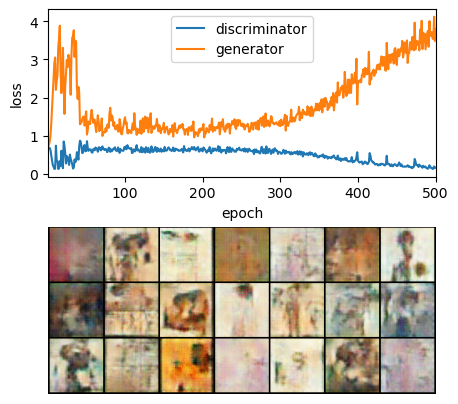

Epoch 500: loss_D=0.159, loss_G=3.801, 925.5 examples/sec on cuda


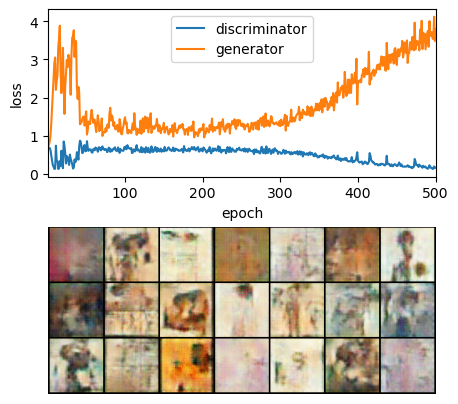

In [ ]:
# expected output

In [ ]:
# TODO: train the GAN model for durer
latent_dim, lr, num_epochs = 100, 0.001, 500
train(net_D, net_G, durer_dataloader, num_epochs, lr, latent_dim)

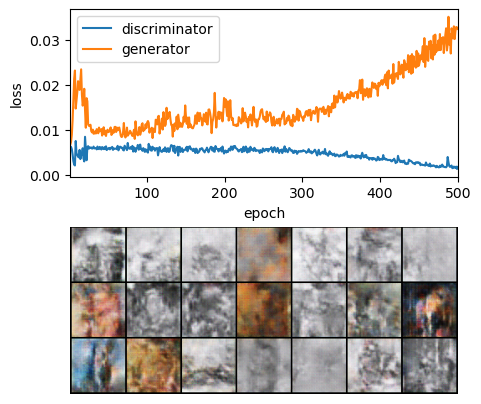

loss_D 0.002, loss_G 0.032, 1162.7 examples/sec on cuda


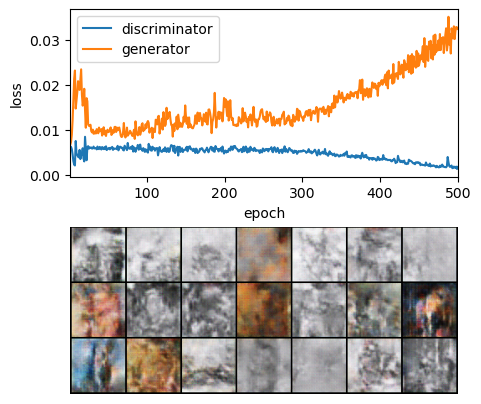

In [ ]:
# expected output

References \& Readings:
- https://developer.ibm.com/articles/generative-adversarial-networks-explained/
- https://github.com/liaopeiyuan/artbench/tree/main?tab=readme-ov-file
- https://developers.google.com/machine-learning/gan/gan_structure
- https://jaketae.github.io/study/pytorch-gan/
- https://d2l.ai/chapter_generative-adversarial-networks/gan.html